In [5]:
import matplotlib.pyplot as plt
# import simpreglib as srl
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats

plt.style.use('fivethirtyeight')

In [2]:
df1=pd.read_csv('data/cleaned_kc.csv')
df2=pd.read_csv('data/kc_house_data.csv')
dfo = df2[['price','grade','sqft_living','sqft_lot','bedrooms','bathrooms']]
df1.drop('waterfront_loc',axis=1,inplace=True)

In [ ]:
pd.plotting.scatter_matrix(dfo,figsize=(12,12))
plt.show()

In [ ]:
pd.plotting.scatter_matrix(df1,figsize=(12,12))
plt.show()

#### Simple linear regression on select features
Assumtion check: 
- is it linear?
- is it normal?
    - histogram
    - Q-Q plot
- is it homoscedastic?

##### For engineered features . . .

In [ ]:
# visualize the relationship between the predictors and the target using scatterplots
fig, axs = plt.subplots(1, 5,sharey=True, figsize=(18, 6))
labels = df1.columns[1:]
for idx, channel in enumerate(labels):
    df1.plot(kind='scatter', x=channel, y='price', ax=axs[idx], label=channel)
    
plt.legend()
plt.show()

In [ ]:
# # For all the variables, check distribution by creating a histogram with kde
for column in df1 :
    df1[column].plot.hist(density=True,label = column+' histogram')
    df1[column].plot.kde(label = column+' kde')
    plt.legend()
    plt.show()

In [6]:
outcome = 'price'
x_cols =  ['day_of_year', 'relative_living_space', 'relative_lot_size','bed_bath_ratio', 'grade']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     1702.
Date:                Sun, 06 Mar 2022   Prob (F-statistic):               0.00
Time:                        20:54:13   Log-Likelihood:            -3.0380e+05
No. Observations:               21597   AIC:                         6.076e+05
Df Residuals:                   21591   BIC:                         6.077e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               1.11e+06   1.08e+04    102.665      0.000    1.09e+06    1.13e+06
day_of_year             -70.0834     22.354     -3.135      0.002    -113.900     -26.267
relative_living_space   203.4459      3.615     56.282      0.000     196.361     210.531
relative_lot_size         0.1045      0.073      1.423      0.155      -0.039       0.249
bed_bath_ratio        -1.082e+05   3228.621    -33.523      0.000   -1.15e+05   -1.02e+05
grade                 -5.567e+04   1122.844    -49.581      0.000   -5.79e+04   -5.35e+04
==============================================================================
Omnibus:                    14649.891   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           416292.258
Skew:                           2.868   Prob(JB):                         0.00
Kurtosis:                      23.729   Cond. No.                     1.51e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

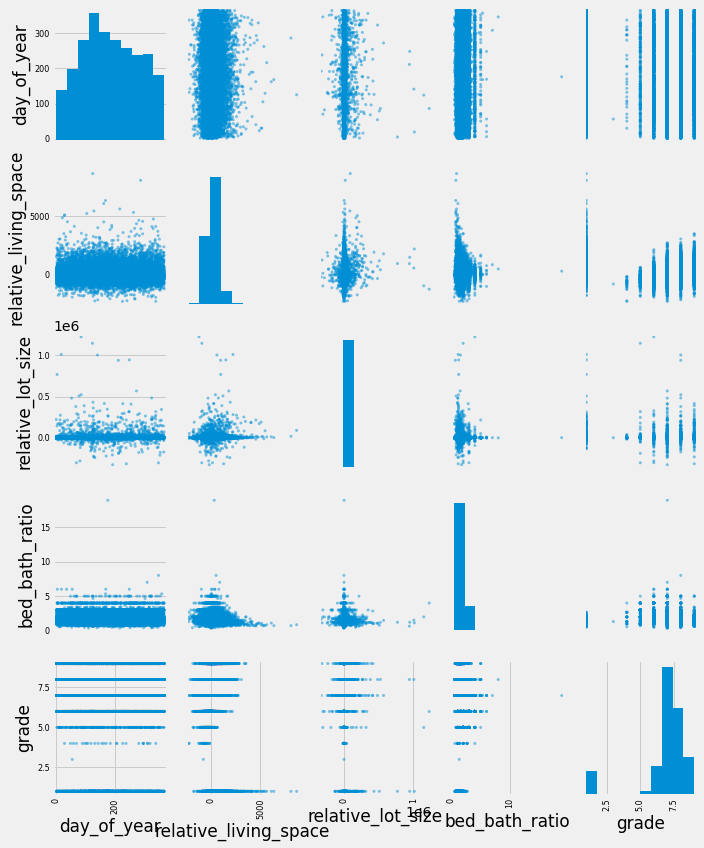

In [9]:
pd.plotting.scatter_matrix(df1[x_cols], figsize=(10,12));
plt.tight_layout()
plt.show()

The plots above show relative living space, and grade to be the most promising

In [10]:
non_normal = list(df1.columns[1:])

# log transform data frame
for feat in non_normal: 
    df1[feat] = df1[feat].map(lambda x: np.log(x))
    df1.loc[df1[feat].isnull()] = 0

 # deal with valuable zeros
for feat in ['relative_living_space','relative_lot_size']:
    df1[feat] = df1[feat].fillna(0)

 # deal with -inf values
for label in df1.columns: # deal with -inf values
    df1.drop(df1.index[df1[label] == np.NINF], inplace=True)


<ipython-input-10-4bd97a7b3af6>:5: RuntimeWarning: invalid value encountered in log
  df1[feat] = df1[feat].map(lambda x: np.log(x))
<ipython-input-10-4bd97a7b3af6>:5: RuntimeWarning: divide by zero encountered in log
  df1[feat] = df1[feat].map(lambda x: np.log(x))


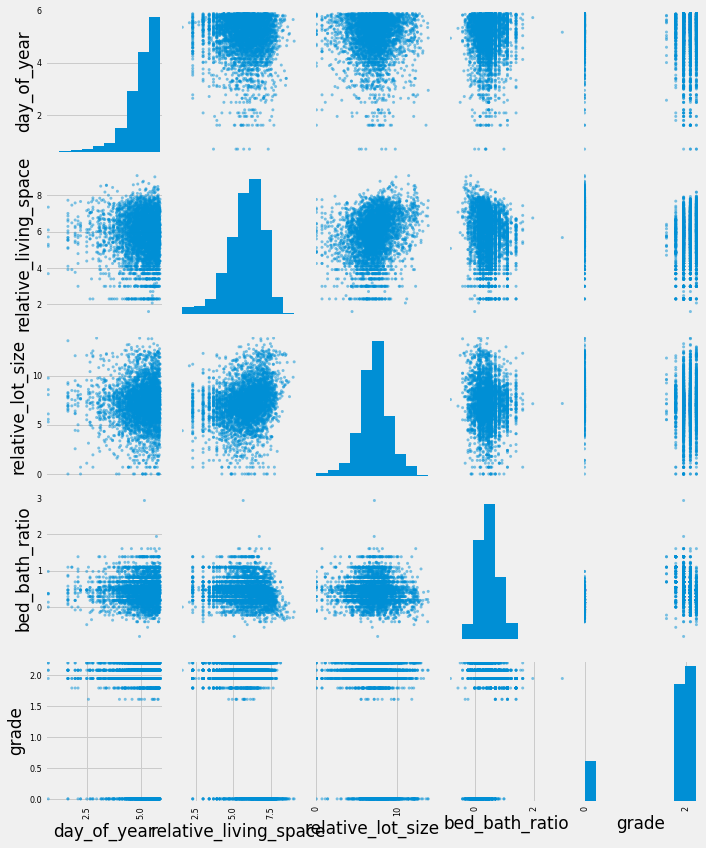

In [11]:
pd.plotting.scatter_matrix(df1[x_cols], figsize=(10,12));
plt.tight_layout()
plt.show()

In [12]:
fspace = 'price~relative_living_space'
fsize = 'price~relative_lot_size'
fgrade = 'price~grade'
fday = 'price~day_of_year'
fbb = 'price~bed_bath_ratio'

space_model = smf.ols(formula=fspace, data=df1).fit()
size_model = smf.ols(formula=fsize, data=df1).fit()
grade_model = smf.ols(formula=fgrade, data=df1).fit()
day_model = smf.ols(formula=fday, data=df1).fit()
fbb_model = smf.ols(formula=fbb, data=df1).fit()

In [13]:
print(space_model.pvalues)
space_model.summary()

Intercept                 5.230217e-11
relative_living_space    1.703548e-135
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     659.8
Date:                Sun, 06 Mar 2022   Prob (F-statistic):          1.70e-135
Time:                        20:58:11   Log-Likelihood:                -62293.
No. Observations:                4304   AIC:                         1.246e+05
Df Residuals:                    4302   BIC:                         1.246e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -2.343e+05   3.56e+04     -6.581      0.000   -3.04e+05   -1.64e+05
relative_living_space  1.536e+05   5978.636     25.686      0.000    1.42e+05    1.65e+05
==============================================================================
Omnibus:                     3642.757   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           158074.647
Skew:                           3.809   Prob(JB):                         0.00
Kurtosis:                      31.696   Cond. No.                         30.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
print(size_model.pvalues)
size_model.summary()

Intercept            3.512239e-43
relative_lot_size    1.015514e-23
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     102.0
Date:                Sun, 06 Mar 2022   Prob (F-statistic):           1.02e-23
Time:                        20:58:12   Log-Likelihood:                -62550.
No. Observations:                4304   AIC:                         1.251e+05
Df Residuals:                    4302   BIC:                         1.251e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3.896e+05    2.8e+04     13.931      0.000    3.35e+05    4.44e+05
relative_lot_size  3.801e+04   3763.181     10.100      0.000    3.06e+04    4.54e+04
==============================================================================
Omnibus:                     3805.000   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           174859.549
Skew:                           4.068   Prob(JB):                         0.00
Kurtosis:                      33.148   Cond. No.                         28.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
print(grade_model.pvalues)
grade_model.summary()

Intercept    0.0
grade        0.0
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     1849.
Date:                Sun, 06 Mar 2022   Prob (F-statistic):               0.00
Time:                        20:58:12   Log-Likelihood:                -61830.
No. Observations:                4304   AIC:                         1.237e+05
Df Residuals:                    4302   BIC:                         1.237e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.339e+06    1.7e+04     78.757      0.000    1.31e+06    1.37e+06
grade      -3.878e+05   9017.833    -43.004      0.000   -4.05e+05    -3.7e+05
==============================================================================
Omnibus:                     3723.107   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           215306.498
Skew:                           3.829   Prob(JB):                         0.00
Kurtosis:                      36.793   Cond. No.                         6.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
print(day_model.pvalues)
day_model.summary()

Intercept      6.014934e-36
day_of_year    8.181728e-01
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.05286
Date:                Sun, 06 Mar 2022   Prob (F-statistic):              0.818
Time:                        20:58:12   Log-Likelihood:                -62600.
No. Observations:                4304   AIC:                         1.252e+05
Df Residuals:                    4302   BIC:                         1.252e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    6.499e+05   5.14e+04     12.633      0.000    5.49e+05    7.51e+05
day_of_year  2323.9789   1.01e+04      0.230      0.818   -1.75e+04    2.21e+04
==============================================================================
Omnibus:                     3817.722   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           175436.594
Skew:                           4.090   Prob(JB):                         0.00
Kurtosis:                      33.189   Cond. No.                         35.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
print(fbb_model.pvalues)
fbb_model.summary()

Intercept          0.000000e+00
bed_bath_ratio    2.607152e-108
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     517.7
Date:                Sun, 06 Mar 2022   Prob (F-statistic):          2.61e-108
Time:                        20:58:12   Log-Likelihood:                -62355.
No. Observations:                4304   AIC:                         1.247e+05
Df Residuals:                    4302   BIC:                         1.247e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       8.905e+05   1.24e+04     71.888      0.000    8.66e+05    9.15e+05
bed_bath_ratio  -5.07e+05   2.23e+04    -22.753      0.000   -5.51e+05   -4.63e+05
==============================================================================
Omnibus:                     3747.878   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           177307.590
Skew:                           3.954   Prob(JB):                         0.00
Kurtosis:                      33.433   Cond. No.                         3.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""